# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [2]:
data.shape

(13150, 10)

In [3]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [5]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [6]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [7]:

def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [8]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [9]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [10]:
tree_manual = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree_manual

{'y_pred': 1,
 'y_prob': 0.5780753517930095,
 'level': 0,
 'split': [1, 52187.63636363637],
 'n_samples': 8810,
 'gain': 0.23872134898880762,
 'sl': {'y_pred': 1,
  'y_prob': 0.8391583452211127,
  'level': 1,
  'split': [0, 2014.0],
  'n_samples': 5606,
  'gain': 0.03317687167496233,
  'sl': {'y_pred': 0,
   'y_prob': 0.36828644501278773,
   'level': 2,
   'split': [0, 2012.0],
   'n_samples': 389,
   'gain': 0.05908490521197157,
   'sl': {'y_pred': 0,
    'y_prob': 0.08,
    'level': 3,
    'split': -1,
    'n_samples': 98,
    'gain': 0.01707452211653898},
   'sr': {'y_pred': 0,
    'y_prob': 0.46757679180887374,
    'level': 3,
    'split': -1,
    'n_samples': 291,
    'gain': 0.036947257392555666}},
  'sr': {'y_pred': 1,
   'y_prob': 0.8743054224947308,
   'level': 2,
   'split': [0, 2015.0],
   'n_samples': 5217,
   'gain': 0.014933378976312917,
   'sl': {'y_pred': 1,
    'y_prob': 0.7348484848484849,
    'level': 3,
    'split': -1,
    'n_samples': 1450,
    'gain': 0.024495220

In [11]:
y_11_1 = tree_predict(X_test, tree_manual)

In [12]:
y_11_1

array([0., 1., 1., ..., 1., 1., 0.])

In [13]:
from sklearn import metrics

In [14]:
metrics.accuracy_score(y_test, y_11_1)

0.8610599078341014

El modelo se ajusta en un 86% a los datos. 

# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [15]:
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

In [16]:
# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B+1)]

print(samples)

[array([3582, 1346, 5218, ..., 5288, 5094, 8043]), array([ 431, 3426, 8463, ..., 8218,  237, 8326]), array([8477, 4773, 5743, ..., 1809,  214, 6910]), array([5885, 1492, 7249, ..., 1834,  137, 7586]), array([ 352, 4574, 5708, ..., 7142, 2081, 7438]), array([2311, 6342, 4124, ..., 8286, 8453, 1222]), array([5003, 7878, 7832, ..., 3522,  407, 3676]), array([6901, 1829, 1437, ..., 8100, 3585,  522]), array([2874, 2197, 2888, ...,  477, 5922, 4068]), array([5547, 7784, 7473, ..., 4908, 6648, 3622])]


In [17]:
# DataFrame for storing predicted price from each tree
y_pred_11_3 = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
# grow one tree for each bootstrap sample and make predictions on testing data
for i, sample in enumerate(samples):
    X_train = X_train.iloc[sample]  # X_train.iloc[sample]
    y_train = y_train.iloc[sample]
    tree2 = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)
    y_pred_11_3[i] = tree_predict(X_test, tree2)

for i in range(n_B):
    print(i, accuracy_score(y_test, y_pred_11_3[i]))

y_pred_11_2 = y_pred_11_3.mean(axis=1).astype(int)

print('Accuracy: \n', accuracy_score(y_test, y_pred_11_2))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred_11_2))

0 0.8670506912442396
1 0.8624423963133641
2 0.8631336405529954
3 0.8658986175115208
4 0.8642857142857143
5 0.8642857142857143
6 0.8661290322580645
7 0.8642857142857143
8 0.8661290322580645
9 0.8642857142857143
Accuracy: 
 0.8631336405529954
Confusion Matrix: 
 [[1485  327]
 [ 267 2261]]


Cuando realizamos el accuracy general, encontramos un ajuste de modelo un 86,31%. Al realizar el Bagging se realiza un mejor ajuste de acuerdo al modelo anterior. 

# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [19]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

feature_cols = data.columns[data.columns.str.startswith('C')==False].drop('HighPrice')
print(feature_cols)

Index(['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL',
       'M_CamryLE', 'M_CamrySE', 'M_CamryXLE'],
      dtype='object')


In [20]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []


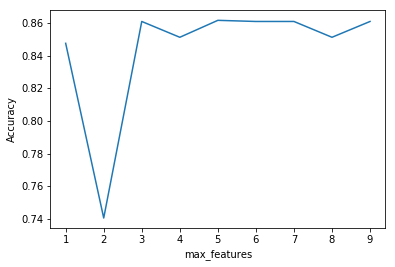


Exercise 11.3

Best_accuracy, Best_#features: 
 (0.8615207373271889, 5)


In [21]:
for feature in feature_range:
    clf3 = DecisionTreeClassifier(max_depth=3, max_features=feature, random_state=1)
    clf3.fit(X_train, y_train)
    y_pred_11_3 = clf3.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred_11_3))

plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.show()

print('\nExercise 11.3\n')
print('Best_accuracy, Best_#features: \n', sorted(zip(accuracy_scores, feature_range))[::-1][0])


Cuando se realiza el Max:feature el ajuste del modelo mejora aproximadamente el 4%: 

# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [22]:
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B+1)]

print(samples)

[array([3582, 1346, 5218, ..., 5288, 5094, 8043]), array([ 431, 3426, 8463, ..., 8218,  237, 8326]), array([8477, 4773, 5743, ..., 1809,  214, 6910]), array([5885, 1492, 7249, ..., 1834,  137, 7586]), array([ 352, 4574, 5708, ..., 7142, 2081, 7438]), array([2311, 6342, 4124, ..., 8286, 8453, 1222]), array([5003, 7878, 7832, ..., 3522,  407, 3676]), array([6901, 1829, 1437, ..., 8100, 3585,  522]), array([2874, 2197, 2888, ...,  477, 5922, 4068]), array([5547, 7784, 7473, ..., 4908, 6648, 3622])]


In [33]:
y_pred_11_4 = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# grow one tree for each bootstrap sample and make predictions on testing data
print('log(n_features): \n', np.ceil(np.log(len(feature_cols) + 1)))

for i, sample in enumerate(samples):
    X_train = X_train.iloc[sample]
    y_train = y_train.iloc[sample]
    clf4 = DecisionTreeClassifier(max_depth=3, max_features=3, random_state=1)
    clf4.fit(X_train, y_train)
    y_pred_11_4[i] = clf4.predict(X_test).astype(int)
    

for i in range(n_B):
    print(i, accuracy_score(y_test, y_pred_11_4[i]))

y_pred_11_4_final = y_pred_11_4.mean(axis=1).astype(int)

print('Accuracy: \n', accuracy_score(y_test, y_pred_11_4_final))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred_11_4_final))


log(n_features): 
 3.0
0 0.8615207373271889
1 0.8647465437788019
2 0.864516129032258
3 0.8642857142857143
4 0.8615207373271889
5 0.8642857142857143
6 0.8347926267281106
7 0.8615207373271889
8 0.8615207373271889
9 0.8347926267281106
Accuracy: 
 0.8534562211981567
Confusion Matrix: 
 [[1506  306]
 [ 330 2198]]


Cuando se realiza el ajuste en  `max_features = log(n_features)` el modelo se ajusta en un 85.34%. 

# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [24]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

C:\Users\MLNDGIL\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [25]:
clf.fit(X_train,y_train) #Entrenando el modelo

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
y_predict = clf.predict(X_test) #prediciendo el modelo

In [27]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [28]:
EJ11_5a = metrics.accuracy_score(y_test, y_predict)
EJ11_5a

0.8315668202764976

Cuando realizamos el accuracy para este punto, el modelo se ajusta en un 83,15%.

# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [29]:
from sklearn.model_selection import cross_val_score
max_depth_range = range(1, 21)

# list to store the accuracy for each value of max_depth
accuracy_scores = []

# use 10-fold cross-validation with each value of max_depth
for depth in max_depth_range:
    clf6_1 = RandomForestClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf6_1, X, y, cv=10, scoring='accuracy').mean())

print('Best_depth: \n', sorted(zip(accuracy_scores, max_depth_range))[::-1][0])


Best_depth: 
 (0.881293109097012, 9)


In [30]:
# MAX_FEATURES

feature_cols = data.columns[data.columns.str.startswith('C')==False].drop('HighPrice')
print(feature_cols)

# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features
for feature in feature_range:
    clf6_2 = RandomForestClassifier(max_depth=9, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf6_2, X, y, cv=10, scoring='accuracy').mean())

print('Best_#features: \n', sorted(zip(accuracy_scores, feature_range))[::-1][0])


Index(['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL',
       'M_CamryLE', 'M_CamrySE', 'M_CamryXLE'],
      dtype='object')
Best_#features: 
 (0.8815975807095802, 2)


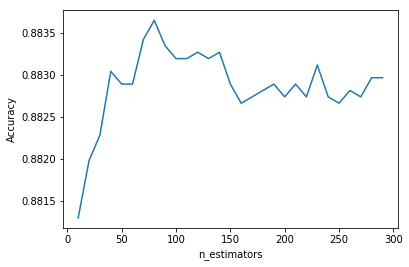

In [31]:
# N_ESTIMATORS

# list of values to try for n_estimators
estimator_range = range(10, 300, 10)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators
for estimator in estimator_range:
    clf6_3 = RandomForestClassifier(max_depth=7, max_features=2, n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf6_3, X, y, cv=5, scoring='accuracy').mean())

# print('Best_estimator: \n', sorted(zip(accuracy_scores, estimator_range))[::-1][0])

plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.show()


In [32]:
# BEST PARAMETERS

clf6_6 = RandomForestClassifier(max_depth=7, max_features=2, n_estimators=200, random_state=1, n_jobs=-1)

clf6_6.fit(X_train, y_train)  # Entrenando el modelo
y_pred_11_6 = clf6_6.predict(X_test)  # prediciendo el modelo

print('\nExercise 11.6\n')
print('Accuracy: \n', accuracy_score(y_test, y_pred_11_6))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred_11_6))


Exercise 11.6

Accuracy: 
 0.8626728110599078
Confusion Matrix: 
 [[1402  410]
 [ 186 2342]]


El modelo que mas se ajusta es cuando se realiza el max_features. 